# Cataract detection 

In this notebook I have attempted to detect cataracts in an human eye.

## Necessary libraries

In [ ]:
import numpy as np
import cv2
import os 
import pandas as pd
from random import sample

import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix as plt_con_mat

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.utils import plot_model

## Loading the data

In [ ]:
path = "../input/ocular-disease-recognition-odir5k"
df = pd.read_csv(os.path.join(path, "full_df.csv"))
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
file_names = []
labels = []

for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["C"], df["Left-Fundus"]):
    
    if(("cataract" in text) and (label == 1)):
        file_names.append(file_name)
        labels.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names.append(file_name)
        labels.append(0)
        
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["C"], df["Right-Fundus"]):
    
    if(("cataract" in text) and (label == 1)):
        file_names.append(file_name)
        labels.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names.append(file_name)
        labels.append(0)

print(len(file_names), len(labels))

6162 6162


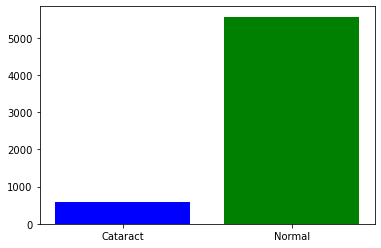

In [ ]:
plt.bar([0,1], [len([i for i in labels if i == 1]), len([i for i in labels if i == 0])], color = ['b', 'g'])
plt.xticks([0, 1], ['Cataract', 'Normal'])
plt.show()

## Extracting the data into train and test sets.

In [ ]:
ROW = 224
COL = 224

In [ ]:
image_data = []
for idx, image_name in enumerate(file_names):
    
    img = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        img = cv2.resize(img, (ROW, COL))
        image_data.append(img)
    except:
        del labels[idx]
    
image_data = np.array(image_data)
print(image_data.shape)

(6078, 224, 224, 3)


In [ ]:
temp = []
for idx, label in enumerate(labels):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data[idx])
    y_data.append(labels[idx])

temp = []
for idx, label in enumerate(labels):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data[idx])
    y_data.append(labels[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

print(X_data.shape, y_data.shape)

(1178, 224, 224, 3) (1178, 2)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle = True, random_state = 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(942, 224, 224, 3) (942, 2)
(236, 224, 224, 3) (236, 2)


## CNN model using VGG19

### Transfer learning

In [ ]:
vgg = VGG19(weights = "imagenet", include_top = False, input_shape=(ROW, COL, 3))
for layer in vgg.layers:
    layer.trainable = False

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(2,activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1605696   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 21,630,210
Trainable params: 1,605,826
Non-trainable params: 20,024,384
_________________________________________________________________


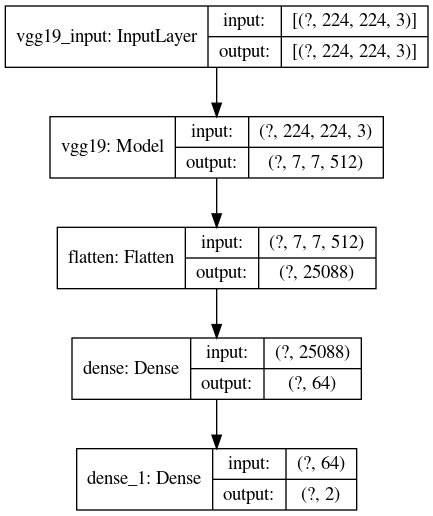

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Training the CNN model

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    epochs = 15,
                    batch_size = 64)

Epoch 1/15
15/15 [==============================] - 377s 25s/step - loss: 3.1747 - accuracy: 0.8217 - precision: 0.8217 - recall: 0.8217 - val_loss: 1.0510 - val_accuracy: 0.8644 - val_precision: 0.8644 - val_recall: 0.8644
Epoch 2/15
15/15 [==============================] - 383s 26s/step - loss: 1.3771 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - val_loss: 1.2126 - val_accuracy: 0.9195 - val_precision: 0.9195 - val_recall: 0.9195
Epoch 3/15
15/15 [==============================] - 381s 25s/step - loss: 0.7145 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - val_loss: 1.8010 - val_accuracy: 0.8517 - val_precision: 0.8517 - val_recall: 0.8517
Epoch 4/15
15/15 [==============================] - 378s 25s/step - loss: 0.5645 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - val_loss: 1.5583 - val_accuracy: 0.8941 - val_precision: 0.8941 - val_recall: 0.8941
Epoch 5/15
15/15 [==============================] - 388s 26s/step - loss: 0.4378 - accuracy: 0.9522 - pr

## Model training performance

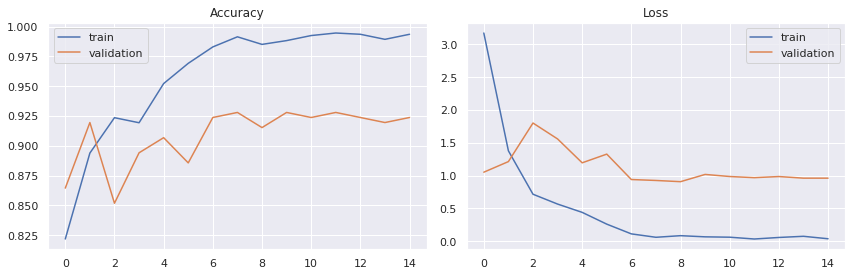

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label = 'train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label = 'validation')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label = 'train')
sns.lineplot(history.epoch, history.history['val_loss'], label = 'validation')
plt.title('Loss')
plt.tight_layout()

#plt.savefig('epoch_history.png')
plt.show()

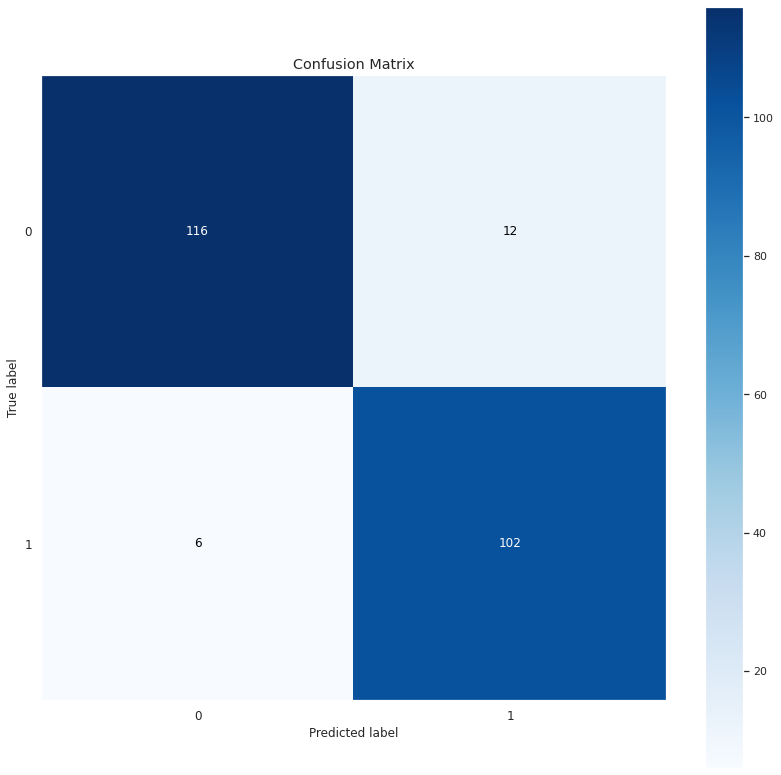

In [ ]:
preds = model.predict_classes(X_test)
y_true = np.argmax(y_test, axis=1)

plt_con_mat(y_true, preds, figsize=(14,14))
plt.show()

In [ ]:
import tensorflow as tf
tf.keras.models.save_model(model,'model.h5')